In [239]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

sns.set_theme(style="white")
print(xgboost.__version__)

1.7.6


In [240]:
df = pd.read_csv("./datasets/Data_Science_Challenge.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

In [241]:
# O stand for object
object_cols = [col for col in df.columns if df[col].dtype=="O"]
print(object_cols)
print(df[object_cols].isna().mean().sort_values(ascending=False))
print()
numeric_cols = df.select_dtypes(include=np.number).columns
print(df[numeric_cols].isna().mean())

['state', 'phone number', 'international plan', 'voice mail plan']
state                 0.0
phone number          0.0
international plan    0.0
voice mail plan       0.0
dtype: float64

account length            0.0
area code                 0.0
number vmail messages     0.0
total day minutes         0.0
total day calls           0.0
total day charge          0.0
total eve minutes         0.0
total eve calls           0.0
total eve charge          0.0
total night minutes       0.0
total night calls         0.0
total night charge        0.0
total intl minutes        0.0
total intl calls          0.0
total intl charge         0.0
customer service calls    0.0
dtype: float64


In [242]:
df[object_cols].head()

,state,phone number,international plan,voice mail plan
0,KS,382-4657,no,yes
1,OH,371-7191,no,yes
2,NJ,358-1921,no,no
3,OH,375-9999,yes,no
4,OK,330-6626,yes,no


In [243]:
df.drop(columns=["phone number"], inplace=True)
object_cols = [col for col in df.columns if df[col].dtype=="O"]


In [244]:
corr = df[numeric_cols].corr()
print(corr.shape)

(16, 16)


In [245]:
### generate mask for upper triangel
mask = np.triu(np.ones_like(corr, dtype=bool), k=0)

<Axes: >

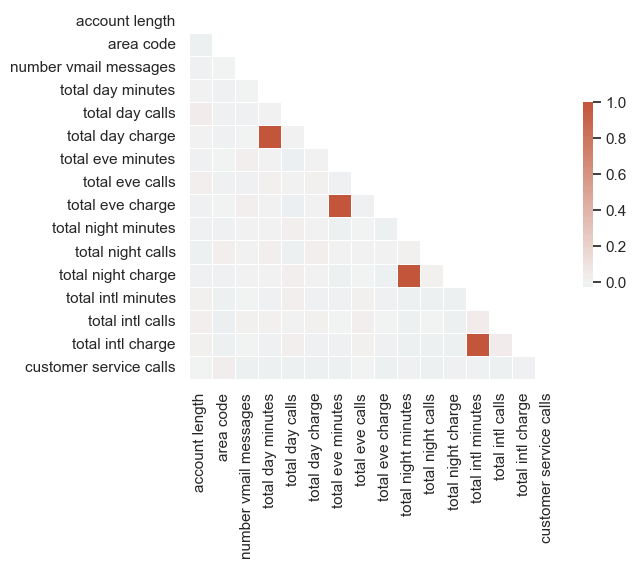

In [246]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, vmax=1.0, center=0, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [247]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# X = df.drop(columns=["churn"])
# y = df["churn"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

from sklearn.utils import shuffle
df = shuffle(df)
df_train, df_test = train_test_split(df, test_size=0.3)
print(df_train.shape, df_test.shape)



(2333, 20) (1000, 20)


In [248]:
df_train_majority = df_train[df_train["churn"]==False].reset_index(drop=True)
df_train_minority = df_train[df_train["churn"]==True].reset_index(drop=True)

# Downsample majority class
df_majority_downsampled = resample(df_train_majority, 
                                 replace=True,    
                                 n_samples=2000)
#Upsample minority class
df_minority_upsampled = resample(df_train_minority, 
                                 replace=True,     
                                 n_samples=2000)

df_up_down_sampled =  pd.concat([df_majority_downsampled.copy(), df_minority_upsampled.copy()]).reset_index(drop=True)
print(df_up_down_sampled.shape)



(4000, 20)


In [249]:
X_train = df_up_down_sampled.drop(columns=["churn"])
y_train = df_up_down_sampled["churn"]

X_test = df_test.drop(columns=["churn"])
y_test = df_test["churn"]

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_values = one_hot_encoder.fit_transform(X_train[object_cols])
one_hot_cols = columns=[item for sublist in one_hot_encoder.categories_ for item in sublist]
one_hot_cols = [f"{col}_{idx}" for idx, col in enumerate(one_hot_cols)]
print(one_hot_cols)

['AK_0', 'AL_1', 'AR_2', 'AZ_3', 'CA_4', 'CO_5', 'CT_6', 'DC_7', 'DE_8', 'FL_9', 'GA_10', 'HI_11', 'IA_12', 'ID_13', 'IL_14', 'IN_15', 'KS_16', 'KY_17', 'LA_18', 'MA_19', 'MD_20', 'ME_21', 'MI_22', 'MN_23', 'MO_24', 'MS_25', 'MT_26', 'NC_27', 'ND_28', 'NE_29', 'NH_30', 'NJ_31', 'NM_32', 'NV_33', 'NY_34', 'OH_35', 'OK_36', 'OR_37', 'PA_38', 'RI_39', 'SC_40', 'SD_41', 'TN_42', 'TX_43', 'UT_44', 'VA_45', 'VT_46', 'WA_47', 'WI_48', 'WV_49', 'WY_50', 'no_51', 'yes_52', 'no_53', 'yes_54']


In [250]:
encoded_dataframe = pd.DataFrame(encoded_values, columns=one_hot_cols)
X_train.drop(columns=object_cols, inplace=True)
X_train = pd.concat([X_train.reset_index(drop=True), encoded_dataframe], axis="columns")

In [251]:
X_train.shape

(4000, 71)

In [252]:
bst = xgboost.XGBRFClassifier(objective='binary:logistic', verbosity=2, scale_pos_weight=1)
bst.fit(X_train, y_train)

[21:56:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=6
[21:56:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[21:56:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:56:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[21:56:55] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra 

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None,
                reg_alpha=None, ...)

In [253]:
test_encoded_dataframe = pd.DataFrame(one_hot_encoder.transform(X_test[object_cols]), columns=one_hot_cols)
test_df = pd.concat([X_test.drop(columns=object_cols).reset_index(drop=True), test_encoded_dataframe], axis="columns")

In [254]:
all(test_df.columns.isin(X_train.columns))

True

In [255]:
from sklearn.metrics import classification_report, f1_score
print(classification_report(y_true=y_test.values, y_pred=bst.predict(test_df)))

              precision    recall  f1-score   support

       False       0.96      0.95      0.96       866
        True       0.71      0.76      0.74       134

    accuracy                           0.93      1000
   macro avg       0.84      0.86      0.85      1000
weighted avg       0.93      0.93      0.93      1000



In [256]:
df["churn"].value_counts()

churn
False    2850
True      483
Name: count, dtype: int64

In [257]:
from collections import Counter
cnt = Counter(y_train)
est = cnt[0]/cnt[1]
print(f"Estimate {est:.3f}")

Estimate 1.000
